# Download data

In [1]:
print("OK")

OK


# Libraries for Datasphere

In [3]:
%pip install -U transformers datasets evaluate accelerate

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Get model

In [4]:
import transformers

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
#from transformers import pipeline
unmasker = transformers.pipeline('fill-mask', model='distilbert-base-uncased')
unmasker("Hello I'm a [MASK] model.")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-06 10:49:49.341826: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 10:49:50.575924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following ins

[{'score': 0.052928660064935684,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i ' m a role model."},
 {'score': 0.03968578204512596,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i ' m a fashion model."},
 {'score': 0.034743670374155045,
  'token': 2449,
  'token_str': 'business',
  'sequence': "hello i ' m a business model."},
 {'score': 0.03462282568216324,
  'token': 2944,
  'token_str': 'model',
  'sequence': "hello i ' m a model model."},
 {'score': 0.018145214766263962,
  'token': 11643,
  'token_str': 'modeling',
  'sequence': "hello i ' m a modeling model."}]

In [6]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

import evaluate
import glob
import numpy as np

In [7]:
BATCH_SIZE = 32
NUM_PROCS = 32
LR = 0.00005
EPOCHS = 5
MODEL = 'bert-base-uncased'
OUT_DIR = 'arxiv_bert'

In [8]:
train_dataset = load_dataset("ccdv/arxiv-classification", split='train')
valid_dataset = load_dataset("ccdv/arxiv-classification", split='validation')
test_dataset = load_dataset("ccdv/arxiv-classification", split='test')
print(train_dataset)
print(valid_dataset)
print(test_dataset)

Generating test split: 100%|██████████| 2500/2500 [00:09<00:00, 259.14 examples/s] 


Dataset({
    features: ['text', 'label'],
    num_rows: 28388
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})


In [9]:
# Visualize a sample.
train_dataset[0]

{'text': 'Constrained Submodular Maximization via a\nNon-symmetric Technique\n\narXiv:1611.03253v1 [cs.DS] 10 Nov 2016\n\nNiv Buchbinder∗\n\nMoran Feldman†\n\nNovember 11, 2016\n\nAbstract\nThe study of combinatorial optimization problems with a submodular objective has attracted\nmuch attention in recent years. Such problems are important in both theory and practice because\ntheir objective functions are very general. Obtaining further improvements for many submodular\nmaximization problems boils down to finding better algorithms for optimizing a relaxation of\nthem known as the multilinear extension.\nIn this work we present an algorithm for optimizing the multilinear relaxation whose guarantee improves over the guarantee of the best previous algorithm (which was given by Ene\nand Nguyen (2016)). Moreover, our algorithm is based on a new technique which is, arguably,\nsimpler and more natural for the problem at hand. In a nutshell, previous algorithms for this\nproblem rely on symmet

In [10]:
id2label = {
    0: "math.AC",
    1: "cs.CV",
    2: "cs.AI",
    3: "cs.SY",
    4: "math.GR",
    5: "cs.CE",
    6: "cs.PL",
    7: "cs.IT",
    8: "cs.DS",
    9: "cs.NE",
    10: "math.ST"
}
label2id = {
    "math.AC": 0,
    "cs.CV": 1,
    "cs.AI": 2,
    "cs.SY": 3,
    "math.GR": 4,
    "cs.CE": 5,
    "cs.PL": 6,
    "cs.IT": 7,
    "cs.DS": 8,
    "cs.NE": 9,
    "math.ST": 10
}

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [12]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
    )

In [13]:
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

tokenized_valid = valid_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

Map (num_proc=32): 100%|██████████| 2500/2500 [00:30<00:00, 81.26 examples/s] 


In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
tokenized_sample = preprocess_function(train_dataset[0])
print(tokenized_sample)
print(f"Length of tokenized IDs: {len(tokenized_sample.input_ids)}")
print(f"Length of attention mask: {len(tokenized_sample.attention_mask)}")


{'input_ids': [101, 27570, 4942, 5302, 8566, 8017, 20446, 3989, 3081, 1037, 2512, 1011, 19490, 6028, 12098, 9048, 2615, 1024, 28769, 1012, 6021, 17788, 2509, 2615, 2487, 1031, 20116, 1012, 16233, 1033, 2184, 13292, 2355, 9152, 2615, 20934, 2818, 8428, 4063, 30125, 17866, 26908, 1526, 2281, 2340, 1010, 2355, 10061, 1996, 2817, 1997, 22863, 23207, 4818, 20600, 3471, 2007, 1037, 4942, 5302, 8566, 8017, 7863, 2038, 6296, 2172, 3086, 1999, 3522, 2086, 1012, 2107, 3471, 2024, 2590, 1999, 2119, 3399, 1998, 3218, 2138, 2037, 7863, 4972, 2024, 2200, 2236, 1012, 11381, 2582, 8377, 2005, 2116, 4942, 5302, 8566, 8017, 20446, 3989, 3471, 26077, 2015, 2091, 2000, 4531, 2488, 13792, 2005, 23569, 27605, 6774, 1037, 23370, 1997, 2068, 2124, 2004, 1996, 4800, 4179, 2906, 5331, 1012, 1999, 2023, 2147, 2057, 2556, 2019, 9896, 2005, 23569, 27605, 6774, 1996, 4800, 4179, 2906, 23370, 3005, 11302, 24840, 2058, 1996, 11302, 1997, 1996, 2190, 3025, 9896, 1006, 2029, 2001, 2445, 2011, 4372, 2063, 1998, 16577, 1

In [16]:
tokenized_sample = preprocess_function(train_dataset[0])
print(tokenized_sample)

{'input_ids': [101, 27570, 4942, 5302, 8566, 8017, 20446, 3989, 3081, 1037, 2512, 1011, 19490, 6028, 12098, 9048, 2615, 1024, 28769, 1012, 6021, 17788, 2509, 2615, 2487, 1031, 20116, 1012, 16233, 1033, 2184, 13292, 2355, 9152, 2615, 20934, 2818, 8428, 4063, 30125, 17866, 26908, 1526, 2281, 2340, 1010, 2355, 10061, 1996, 2817, 1997, 22863, 23207, 4818, 20600, 3471, 2007, 1037, 4942, 5302, 8566, 8017, 7863, 2038, 6296, 2172, 3086, 1999, 3522, 2086, 1012, 2107, 3471, 2024, 2590, 1999, 2119, 3399, 1998, 3218, 2138, 2037, 7863, 4972, 2024, 2200, 2236, 1012, 11381, 2582, 8377, 2005, 2116, 4942, 5302, 8566, 8017, 20446, 3989, 3471, 26077, 2015, 2091, 2000, 4531, 2488, 13792, 2005, 23569, 27605, 6774, 1037, 23370, 1997, 2068, 2124, 2004, 1996, 4800, 4179, 2906, 5331, 1012, 1999, 2023, 2147, 2057, 2556, 2019, 9896, 2005, 23569, 27605, 6774, 1996, 4800, 4179, 2906, 23370, 3005, 11302, 24840, 2058, 1996, 11302, 1997, 1996, 2190, 3025, 9896, 1006, 2029, 2001, 2445, 2011, 4372, 2063, 1998, 16577, 1

In [17]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=11,
    id2label=id2label,
    label2id=label2id,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 41.3 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [39]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    learning_rate=LR,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    load_best_model_at_end=True,
    save_total_limit=3,
    fp16=True
)

In [42]:
import wandb

wandb.login(key="55e9b81ea644d5c47e9d7ab4daca53fb6a81dd82")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: Currently logged in as: valker72 (valker72-safonov) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

history = trainer.train()

/tmp/ipykernel_4338/1574851116.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20250406_112115-scxrl9at
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run arxiv_bert
wandb: ⭐️ View project at https://wandb.ai/valker72-safonov/huggingface
wandb: 🚀 View run at https://wandb.ai/valker72-safonov/huggingface/runs/scxrl9at
 11%|█▏        | 500/4440 [03:33<28:15,  2.32it/s]

{'loss': 0.4115, 'grad_norm': 8.740216255187988, 'learning_rate': 4.4380630630630634e-05, 'epoch': 0.56}


 99%|█████████▊| 78/79 [00:11<00:00,  7.39it/s]
                                                  
 20%|██        | 888/4440 [06:31<25:09,  2.35it/s]
                                               

{'eval_loss': 0.46437734365463257, 'eval_accuracy': 0.8532, 'eval_runtime': 11.2492, 'eval_samples_per_second': 222.238, 'eval_steps_per_second': 7.023, 'epoch': 1.0}


 23%|██▎       | 1000/4440 [08:47<24:19,  2.36it/s]  

{'loss': 0.4386, 'grad_norm': 11.727880477905273, 'learning_rate': 3.876126126126126e-05, 'epoch': 1.13}


 34%|███▍      | 1500/4440 [12:20<21:02,  2.33it/s]

{'loss': 0.3349, 'grad_norm': 5.026092529296875, 'learning_rate': 3.313063063063063e-05, 'epoch': 1.69}


 99%|█████████▊| 78/79 [00:10<00:00,  7.49it/s]
                                                   
 40%|████      | 1776/4440 [14:29<18:55,  2.35it/s]
                                               

{'eval_loss': 0.4130833148956299, 'eval_accuracy': 0.87, 'eval_runtime': 10.9469, 'eval_samples_per_second': 228.376, 'eval_steps_per_second': 7.217, 'epoch': 2.0}


 45%|████▌     | 2000/4440 [17:33<17:27,  2.33it/s]   

{'loss': 0.3055, 'grad_norm': 8.759208679199219, 'learning_rate': 2.7500000000000004e-05, 'epoch': 2.25}


 56%|█████▋    | 2500/4440 [21:07<13:48,  2.34it/s]

{'loss': 0.2518, 'grad_norm': 1.1054835319519043, 'learning_rate': 2.186936936936937e-05, 'epoch': 2.82}


 99%|█████████▊| 78/79 [00:10<00:00,  7.55it/s]
                                                   
 60%|██████    | 2664/4440 [22:28<12:31,  2.36it/s]
                                               

{'eval_loss': 0.43447402119636536, 'eval_accuracy': 0.8676, 'eval_runtime': 10.836, 'eval_samples_per_second': 230.713, 'eval_steps_per_second': 7.291, 'epoch': 3.0}


 68%|██████▊   | 3000/4440 [26:19<10:19,  2.32it/s]   

{'loss': 0.2071, 'grad_norm': 1.6640172004699707, 'learning_rate': 1.6250000000000002e-05, 'epoch': 3.38}


 79%|███████▉  | 3500/4440 [29:53<06:43,  2.33it/s]

{'loss': 0.1884, 'grad_norm': 3.1890721321105957, 'learning_rate': 1.061936936936937e-05, 'epoch': 3.94}


 99%|█████████▊| 78/79 [00:10<00:00,  7.46it/s]
                                                   
 80%|████████  | 3552/4440 [30:26<06:16,  2.36it/s]
                                               

{'eval_loss': 0.4622477889060974, 'eval_accuracy': 0.8656, 'eval_runtime': 10.9663, 'eval_samples_per_second': 227.971, 'eval_steps_per_second': 7.204, 'epoch': 4.0}


 90%|█████████ | 4000/4440 [35:06<03:08,  2.34it/s]  

{'loss': 0.1456, 'grad_norm': 6.090281009674072, 'learning_rate': 4.988738738738739e-06, 'epoch': 4.5}


 99%|█████████▊| 78/79 [00:10<00:00,  7.47it/s]
                                                   
100%|██████████| 4440/4440 [38:25<00:00,  2.37it/s]
                                               

{'eval_loss': 0.507489800453186, 'eval_accuracy': 0.8608, 'eval_runtime': 10.9534, 'eval_samples_per_second': 228.24, 'eval_steps_per_second': 7.212, 'epoch': 5.0}


100%|██████████| 4440/4440 [39:53<00:00,  1.85it/s]

{'train_runtime': 2394.9244, 'train_samples_per_second': 59.267, 'train_steps_per_second': 1.854, 'train_loss': 0.271223124083098, 'epoch': 5.0}


In [23]:
import torch
torch.cuda.empty_cache()

In [33]:
import torch
torch.cuda.empty_cache()

In [27]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 700545 KiB |  22412 MiB |  29880 MiB |  29195 MiB |
|       from large pool | 699648 KiB |  22398 MiB |  29794 MiB |  29111 MiB |
|       from small pool |    897 KiB |     14 MiB |     85 MiB |     84 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 700545 KiB |  22412 MiB |  29880 MiB |  29195 MiB |
|       from large pool | 699648 KiB |  22398 MiB |  29794 MiB |

In [49]:
import seaborn as sns
from collections import Counter

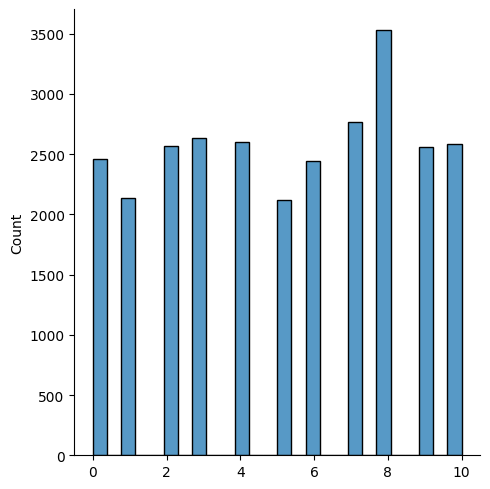

In [53]:
sns.displot(tokenized_train['label'], kde=False);

In [50]:
Counter(tokenized_train['label'])

Counter({8: 3527,
         9: 2560,
         3: 2631,
         5: 2117,
         1: 2137,
         6: 2443,
         0: 2456,
         10: 2581,
         7: 2768,
         2: 2569,
         4: 2599})

In [51]:
print(f"Baseline: {3527 / len(tokenized_train['label'])}")

Baseline: 0.12424263773425391


In [85]:
trainer.evaluate(tokenized_test)

100%|██████████| 79/79 [00:10<00:00,  7.59it/s]


{'eval_loss': 0.3867945075035095,
 'eval_accuracy': 0.88,
 'eval_runtime': 10.5703,
 'eval_samples_per_second': 236.512,
 'eval_steps_per_second': 7.474,
 'epoch': 5.0}

In [86]:
best_model = trainer.state.best_model_checkpoint

In [87]:
best_model

'arxiv_bert/checkpoint-1776'

In [76]:
AutoModelForSequenceClassification.from_pretrained(best_model)
 
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
classify = pipeline(task='text-classification', model=best_model, tokenizer=tokenizer, return_all_scores=True)

Device set to use cuda:0
/home/jupyter/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [77]:
test_input = "AI neural nets batchnorm dropout"

In [78]:
classify(test_input)

[[{'label': 'math.AC', 'score': 0.00019936072931159288},
  {'label': 'cs.CV', 'score': 0.007070641964673996},
  {'label': 'cs.AI', 'score': 0.07817055284976959},
  {'label': 'cs.SY', 'score': 0.001020217896439135},
  {'label': 'math.GR', 'score': 0.0001294235116802156},
  {'label': 'cs.CE', 'score': 0.0018005220917984843},
  {'label': 'cs.PL', 'score': 0.0007135440828278661},
  {'label': 'cs.IT', 'score': 0.0009007487678900361},
  {'label': 'cs.DS', 'score': 0.0005493249045684934},
  {'label': 'cs.NE', 'score': 0.9092284440994263},
  {'label': 'math.ST', 'score': 0.00021719052165281028}]]